In [1]:
import sys
from pathlib import Path

In [2]:
# !{sys.executable} -m pip install -q pyarrow

In [3]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [4]:
import numpy as np
from functools import partial

In [5]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.wrappers.bbox import BBox
from chequeparser.utilities.ds_utils import concat_ds

In [7]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS
from chequeparser.datasets.base import BaseDS

In [9]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_RECOG_PRETRAINED, DOCTR_DETECT_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.detection.doctr import DoctrDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize

In [10]:
from chequeparser.utilities.misc import partition_list
from chequeparser.datasets.loaders import load_yolo

In [11]:
from doctr.models.builder import DocumentBuilder

In [12]:
import pkg_resources
from symspellpy import SymSpell

## config

In [18]:
dir_images = "../data/public/images/"

## testing spell-check

In [11]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [12]:
input_term = (
    "inc"
)
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(
    input_term, 
    max_edit_distance=2, transfer_casing=True,
    split_by_space=True,
    ignore_non_words=True,
    ignore_term_with_digits=True
)

In [13]:
suggestions[0].term

'inc'

## load ds

In [36]:
all_ds = FileDS(dir_images)

Reloading 'chequeparser.datasets.base'.


  0%|          | 0/370 [00:00<?, ?it/s]

2024-02-19 14:35:28.876 | INFO     | chequeparser.utilities.io_utils:get_image_files:31 - Found 369 image files.


In [41]:
rand_id = 57

In [42]:
single_ds = all_ds.get_as_ds(rand_id)

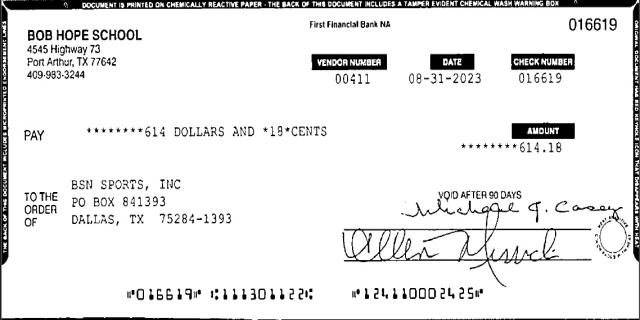

In [43]:
single_ds[0]

## load models

In [70]:
roi_model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [71]:
doctr_det_arch_config = {
    "preserve_aspect_ratio": True,
    "symmetric_pad": True
}
words_model = DoctrDetect(path="db_resnet50", arch=DOCTR_DETECT_PRETRAINED, arch_config = doctr_det_arch_config)

In [72]:
rec_model = DoctrRecognize(path="crnn_vgg16_bn", arch=DOCTR_RECOG_PRETRAINED)

In [73]:
# max edit distance per lookup (per single word, not per whole input string)
spell_checker = partial(sym_spell.lookup_compound,
                        max_edit_distance=2, 
                        transfer_casing=True,
                        split_by_space=True,
                        ignore_non_words=True,
                        ignore_term_with_digits=True
                       )
op_spell_check = lambda x: spell_checker(x)[0].term

NameError: name 'sym_spell' is not defined

## get detections

In [245]:
roi_dets = detect(roi_model, single_ds, stream=False)[0]

2024-02-18 14:48:17.294 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-18 14:48:17.295 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-18 14:48:17.296 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 1 samples



0: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 417.0ms
Speed: 840.3ms preprocess, 417.0ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)


In [246]:
words_dets = detect(words_model, single_ds, stream=False)[0]

2024-02-18 14:48:19.569 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-18 14:48:19.570 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-18 14:48:19.571 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 1 samples


### sort word detections

In [857]:
words_dets.sort_bboxes_lr_()

### filter only anchor and payee dets

In [858]:
filtered_roi_dets = roi_dets.filter_by_labels(["orderof", "payee"], split=True)

In [859]:
anchor_roi_dets, payee_roi_dets = filtered_roi_dets

In [860]:
len(anchor_roi_dets), len(payee_roi_dets)

(1, 1)

## run recognition

In [861]:
words_ds = words_dets.create_ds()

In [862]:
words_recs = recognize(rec_model, words_ds, stream=False)

2024-02-15 23:47:49.297 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-15 23:47:49.297 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: False
2024-02-15 23:47:49.298 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 63 samples


### place words inside boxes

In [863]:
words_recs[0].text

'Bank'

In [864]:
assert len(words_recs) == len(words_dets)

In [865]:
for bbox, rec in zip(words_dets.bboxes, words_recs):
    bbox.content = rec.text

### create lines

In [894]:
doc_builder = DocumentBuilder(export_as_straight_boxes=True, paragraph_break=0.02)

In [895]:
all_words_boxes = words_dets.to_numpy()

In [899]:
bbox_ = words_dets.bboxes

In [903]:
lines = doc_builder._resolve_lines(all_words_boxes)

In [908]:
lines_dets = words_dets.group_boxes(lines)

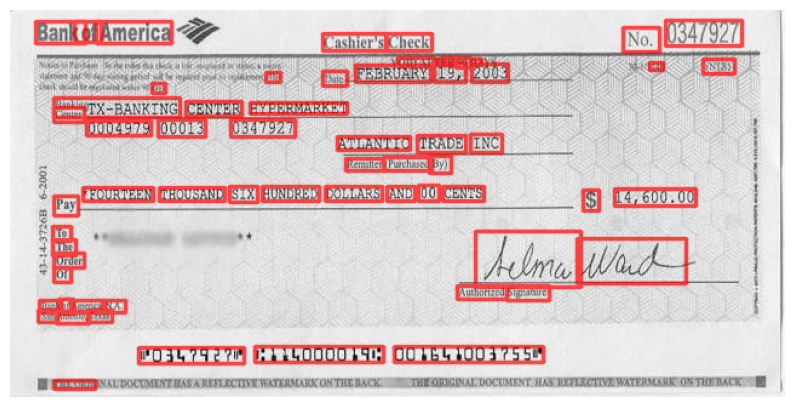

In [909]:
_ = words_dets.draw(display=True, show_label=False, show_conf=False)

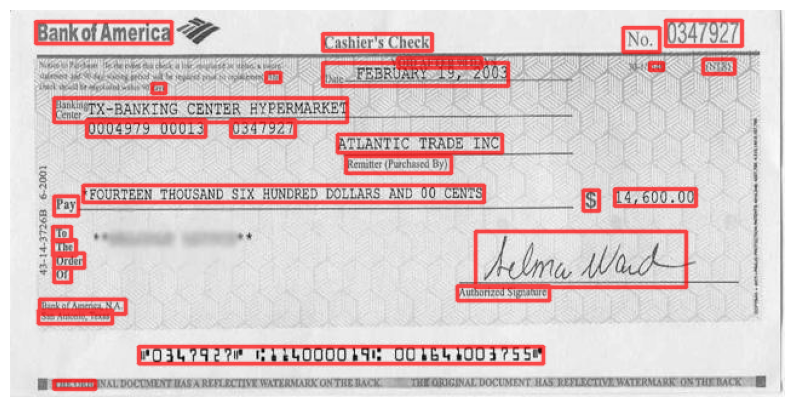

In [910]:
_ = lines_dets.draw(display=True, show_label=False, show_conf=False)

## box intersection b/w roi dets and words dets

In [417]:
candidate_anchor_words_dets = [words_dets.filter_by_bbox(bbox, thresh=0.7)
                              for bbox in anchor_roi_dets.bboxes]

In [418]:
candidate_payee_words_dets = [words_dets.filter_by_bbox(bbox, thresh=0.7)
                              for bbox in payee_roi_dets.bboxes]

In [419]:
_ = [dets.sort_bboxes_lr_()  for dets in candidate_anchor_words_dets]
_ = [dets.sort_bboxes_lr_()  for dets in candidate_payee_words_dets]

## find best anchor candidate

**Criteria (heuristic)**
* Check how many of the words in ["pay", "to", "the", "order", "of"] are found in dets
* Pick the dets with most words found from above

In [428]:
anchor_scores = [sum([1 if keyword in bbox.content.lower() and bbox.x2 > dets.np_img.shape[2]*0.5 else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes]) 
                for dets in candidate_anchor_words_dets]

In [429]:
idx_selected_anchor = max(range(len(anchor_scores)), key=lambda x : anchor_scores[x])

In [430]:
selected_anchor_words_dets = candidate_anchor_words_dets[idx_selected_anchor]
selected_anchor_roi_bbox = anchor_roi_dets.bboxes[idx_selected_anchor]
selected_anchor_score = anchor_scores[idx_selected_anchor]

In [431]:
selected_anchor_roi_dets = anchor_roi_dets.filter_by_bbox(selected_anchor_roi_bbox, thresh=0.95)


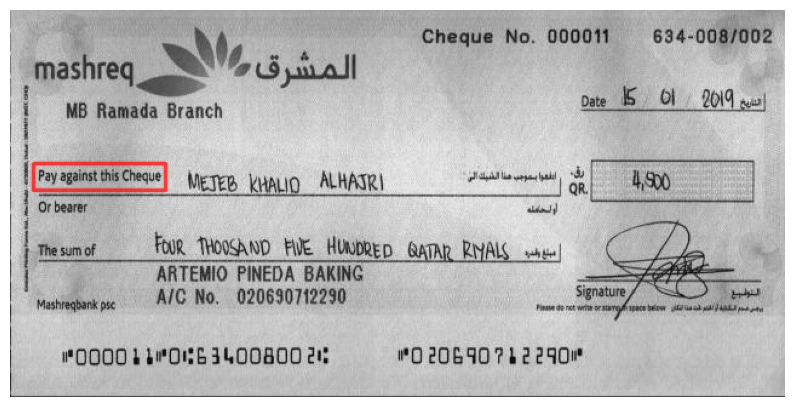

In [432]:
_ = selected_anchor_roi_dets.draw(display=True, show_conf=False, show_label=False)

In [433]:
backup_anchor_dets = words_dets.filter_by_bbox_content("order").filter_by_idxs([0])

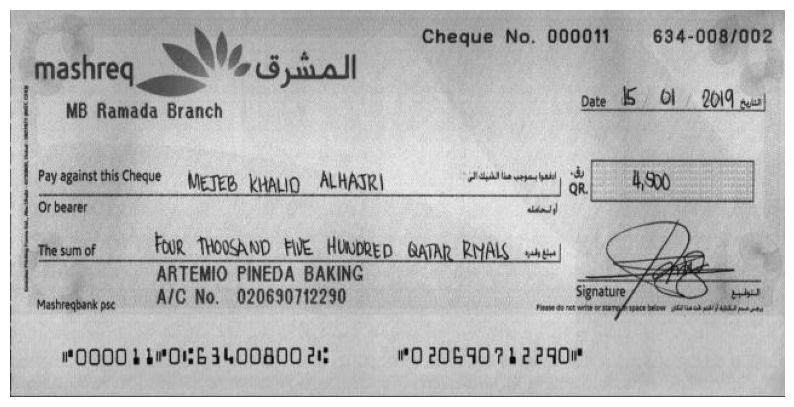

In [434]:
_ = backup_anchor_dets.draw(display=True, show_conf=False, show_label=False)

## find best payee candidate

**Criteria (heuristic)**
* conf filter of 0.6 on payee
* Among bboxes found, compute l2 distance from anchor box
* Use filter bbox by distance for above
* If no anchor, use text classification / llm

In [436]:
high_conf_payee_roi_dets = payee_roi_dets.filter_by_conf(conf=0.6)

In [441]:
anchor_bbox = selected_anchor_roi_bbox

In [442]:
closest_to_anchor_payee_roi_dets = high_conf_payee_roi_dets.filter_by_bbox_dist(anchor_bbox, num_keep=1)

1

## fireproof

In [89]:
PAYEE_NAME = ""

Reloading 'chequeparser.datasets.base'.


### 1. detections and recognitions

In [91]:
roi_dets = detect(roi_model, single_ds, stream=False)[0]

2024-02-19 14:48:49.393 | INFO     | chequeparser.core.detector:detect:34 - Stream mode: False
2024-02-19 14:48:49.394 | INFO     | chequeparser.core.detector:detect:35 - Batched mode: False
2024-02-19 14:48:49.395 | INFO     | chequeparser.core.detector:detect:36 - Running predict on 1 samples



0: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 37.7ms
Speed: 2.2ms preprocess, 37.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


In [95]:
words_dets = detect(words_model, single_ds, stream=False)[0]

2024-02-19 14:50:53.051 | INFO     | chequeparser.core.detector:detect:34 - Stream mode: False
2024-02-19 14:50:53.052 | INFO     | chequeparser.core.detector:detect:35 - Batched mode: False
2024-02-19 14:50:53.052 | INFO     | chequeparser.core.detector:detect:36 - Running predict on 1 samples


Reloading 'chequeparser.wrappers.bbox'.


In [101]:
words_ds = words_dets.create_ds(single_ds)

Reloading 'chequeparser.datasets.base'.


In [111]:
words_recs = recognize(rec_model, words_ds, stream=False)

2024-02-19 14:55:32.114 | INFO     | chequeparser.core.recognizer:recognize:30 - Stream mode: False
2024-02-19 14:55:32.114 | INFO     | chequeparser.core.recognizer:recognize:31 - Batched mode: False
2024-02-19 14:55:32.115 | INFO     | chequeparser.core.recognizer:recognize:32 - Running predict on 64 samples


In [112]:
assert len(words_recs) == len(words_dets)

In [116]:
_ = [box.set_text_and_confidence(rec_results)
     for box, rec_results in zip(words_dets.bboxes, words_recs)]

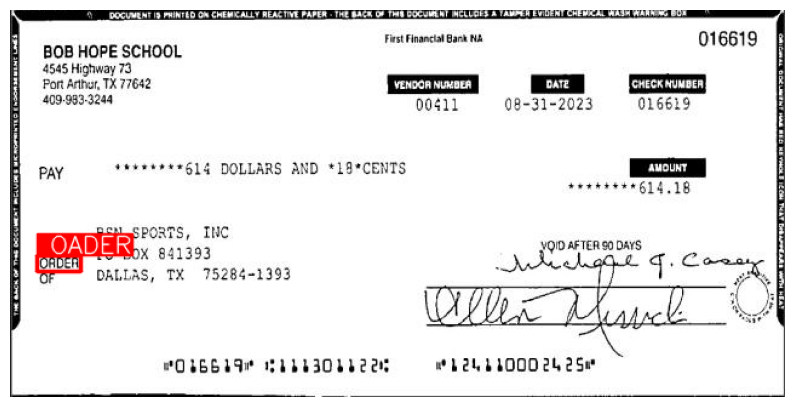

In [123]:
_ = words_dets.filter_by_idxs([9]).draw(
    parent_ds=single_ds,
    show_text=True)

### 2. filtering ROIs

In [32]:
anchor_roi_dets, payee_roi_dets = roi_dets.filter_by_labels(["orderof", "payee"], split=True)

In [33]:
left_half_anchor_rois = anchor_roi_dets.filter_by_x_range(0, 0.35)
left_half_words_dets = words_dets.filter_by_x_range(0, 0.35)

In [34]:
eligible_payee_rois = payee_roi_dets.filter_by_conf(0.6)

In [35]:
high_conf_payee_rois = eligible_payee_rois.filter_by_conf(0.8)

In [36]:
if len(high_conf_payee_rois) > 0:
    best_payee_bbox_id = max(range(len(high_conf_payee_rois)), 
                                key=lambda x: high_conf_payee_rois.bboxes[x].conf)
    best_payee_roi_bbox = high_conf_payee_rois.bboxes[best_payee_bbox_id]
    words_dets_inside_high_conf_payee = words_dets.filter_by_bbox(best_payee_roi_bbox)
    words_dets_inside_high_conf_payee.sort_bboxes_lr_()
    PAYEE_NAME = " ".join(bbox.text for bbox in words_dets_inside_high_conf_payee.bboxes)

In [37]:
PAYEE_NAME

'BSN SPORTS, INC'

### 3. Score anchors and pick best (if not empty)

In [38]:
candidate_anchor_words_dets = [left_half_words_dets.filter_by_bbox(bbox, thresh=0.7)
                              for bbox in left_half_anchor_rois.bboxes]

In [39]:
anchor_scores = [sum([1 if keyword in bbox.text.lower() else 0 
                      for keyword in ["pay", "to", "the", "order", "of"]
                      for bbox in dets.bboxes]) 
                for dets in candidate_anchor_words_dets]

In [40]:
idx_selected_anchor = max(range(len(anchor_scores)), key=lambda x : anchor_scores[x])


In [41]:
selected_anchor_roi = left_half_anchor_rois.filter_by_idxs([idx_selected_anchor])
selected_anchor_score = anchor_scores[idx_selected_anchor]

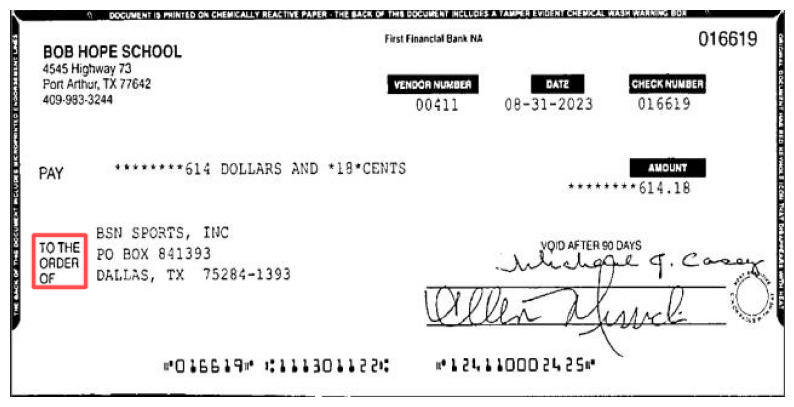

In [42]:
_ = selected_anchor_roi.draw()

### 4. backup anchor (if no anchor roi or best had score 0)

In [43]:
spell_corr_left_half_words_dets = left_half_words_dets.empty()

In [44]:
spell_corr_left_half_words_dets.bboxes = [
    box.apply_text_op(op_spell_check, lowercase=True)
    for box in left_half_words_dets.bboxes
]

In [48]:
backup_anchor_dets = spell_corr_left_half_words_dets.filter_by_bbox_text("order")

In [49]:
backup2_anchor_dets = spell_corr_left_half_words_dets.filter_by_bbox_text("pay")

In [50]:
backup_anchor_dets = backup_anchor_dets.filter_by_idxs([0])
backup2_anchor_dets = backup2_anchor_dets.filter_by_idxs([0])

In [51]:
expanded_backup_anchor_dets = backup_anchor_dets.expand_bboxes(up=2,
                                                               down=1,
                                                               left=0.1,
                                                               right=0.1)

In [52]:
expanded_backup2_anchor_dets = backup2_anchor_dets.expand_bboxes(down=3,
                                                               left=0.5,
                                                               right=0.5)

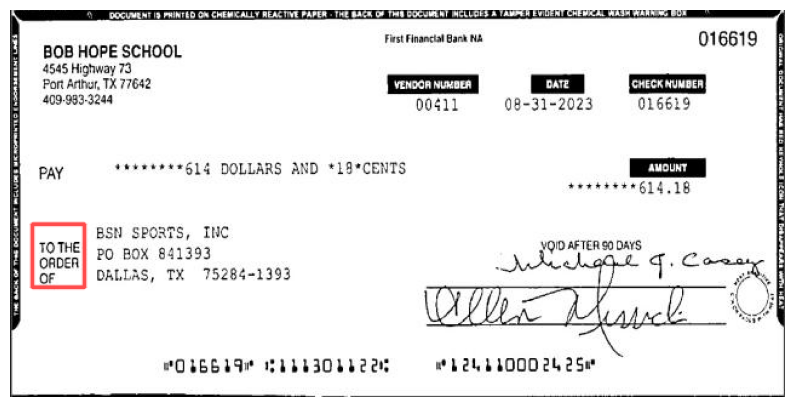

In [55]:
_ = expanded_backup_anchor_dets.draw()

### 5. backup payee

In [84]:
doc_builder = DocumentBuilder(export_as_straight_boxes=True, paragraph_break=0.015)

In [85]:
all_words_boxes = words_dets.to_numpy(normalize=True)

In [86]:
lines = doc_builder._resolve_lines(all_words_boxes)

In [87]:
lines_dets = words_dets.group_boxes(lines)

In [88]:
filtered_lines = lines_dets.filter_by_region(0.05, 0.2,
                                             0.75, 0.8)

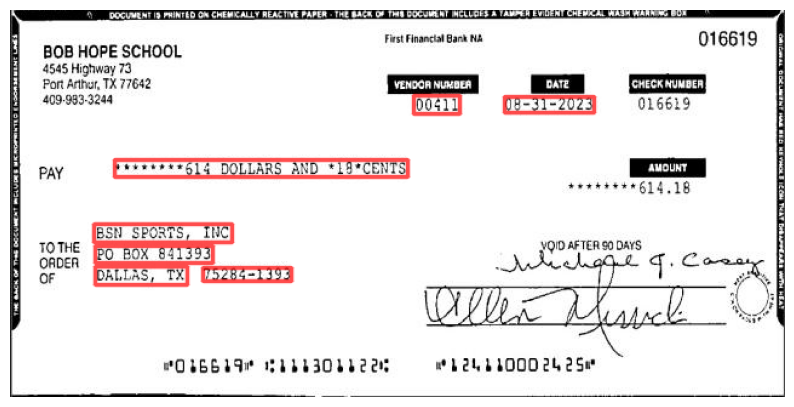

In [89]:
_ = filtered_lines.draw()

### 6. Use anchor to filter out payee rois

In [90]:
extend_anchor_as_region = selected_anchor_roi.expand_bboxes(up=0.2,
                                                            down=0.2,
                                                            left=0,
                                                            right=15)

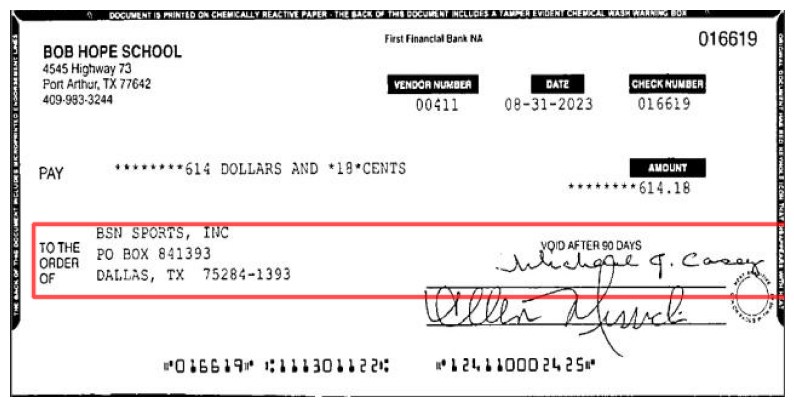

In [91]:
_ = extend_anchor_as_region.draw()

In [92]:
payee_filtered_by_anchor = eligible_payee_rois.filter_by_bbox(extend_anchor_as_region.bboxes[0])

In [93]:
backup_payee_filtered_by_anchor = filtered_lines.filter_by_bbox(extend_anchor_as_region.bboxes[0])

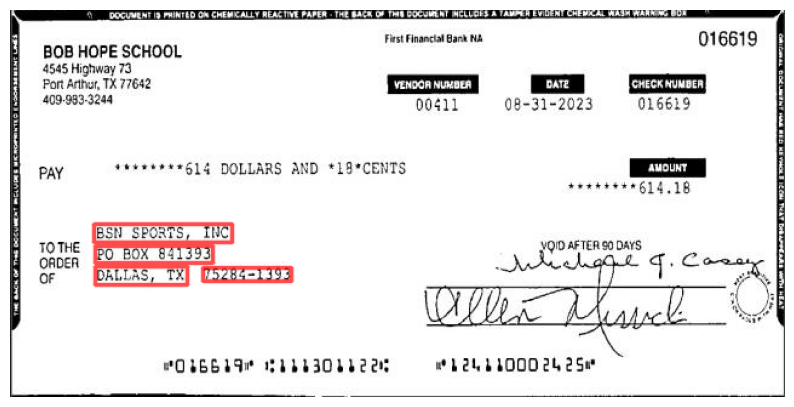

In [94]:
_ = backup_payee_filtered_by_anchor.draw()

## testing sum overload

In [949]:
class A:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def double(self):
        return self.__class__(self.x*2, self.y*2)

    @classmethod
    def from_list(cls, lst):
        x, y = lst
        return cls(x, y)

    def __add__(self, other):
        if isinstance(other, A):
            return A(self.x+other.x, self.y+other.y)
        return self

    def __radd__(self, other):
        return self.__add__(other)

    def __repr__(self):
        return f"x: {self.x}, y: {self.y}"

In [956]:
class B(A):
    def __init__(self, x, y, z=33):
        super().__init__(x, y)
        self.z = z

    def double(self):
        doubled = super().double()
        print(type(doubled))
        return doubled

In [960]:
np.argsort([])

array([], dtype=int64)

In [957]:
A.from_list([3,3])

x: 3, y: 3

In [958]:
B.from_list([3, 4]).z

33

In [937]:
b = B(2, 3, 4)

In [938]:
b.double()

<class '__main__.B'>


x: 4, y: 6

In [465]:
a = A(3, 4)
b = A(4, 7)

In [468]:
sum([b, b, a])

x: 11, y: 18

In [470]:
b, a

(x: 4, y: 7, x: 3, y: 4)

In [472]:
print(b)

x: 4, y: 7


## testing persistence

In [145]:
from chequeparser.utilities.io_utils import save_dets, load_dets

Reloading 'chequeparser.utilities.io_utils'.


In [146]:
save_dets([words_dets], "temp/wdets.h5")

2024-02-19 16:33:26.833 | INFO     | chequeparser.utilities.io_utils:save_dets:69 - Detections saved to temp/wdets.h5


In [181]:
loaded = load_dets("temp/wdets.h5")

Reloading 'chequeparser.wrappers.bbox'.


In [165]:
from ast import literal_eval

## testing gcv

In [138]:
from chequeparser.models.detection.gcv import GCVDetect

Reloading 'chequeparser.models.detection.gcv'.


In [139]:
gcv_model = GCVDetect(svc_acc_path='../../secrets/sva.json')

In [140]:
len(all_ds)

369

In [145]:
gcv_dets = detect(gcv_model, all_ds.get_as_ds(2), stream=False)[0]

2024-02-18 22:14:45.647 | INFO     | chequeparser.core.detector:detect:35 - Stream mode: False
2024-02-18 22:14:45.648 | INFO     | chequeparser.core.detector:detect:36 - Batched mode: False
2024-02-18 22:14:45.649 | INFO     | chequeparser.core.detector:detect:37 - Running predict on 1 samples


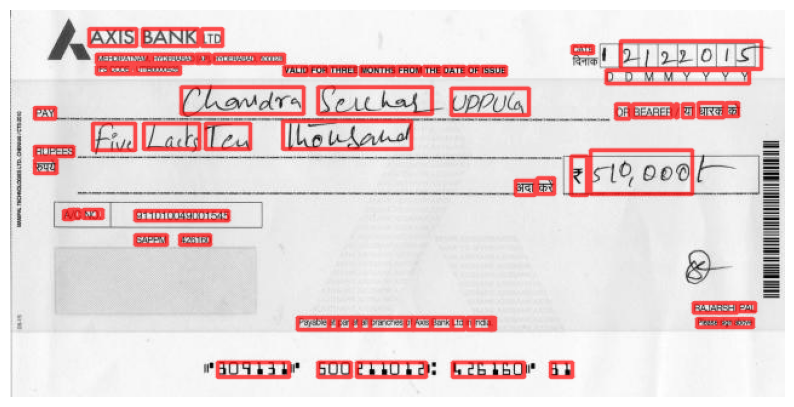

In [146]:
_ = gcv_dets.draw()

In [162]:
words_dets =  detect(words_model, all_ds.batch(bs_idx=0), stream=False)

2024-02-18 22:38:29.538 | INFO     | chequeparser.core.detector:detect:36 - Stream mode: False
2024-02-18 22:38:29.539 | INFO     | chequeparser.core.detector:detect:37 - Batched mode: True
2024-02-18 22:38:29.540 | INFO     | chequeparser.core.detector:detect:38 - Running predict on 4 samples


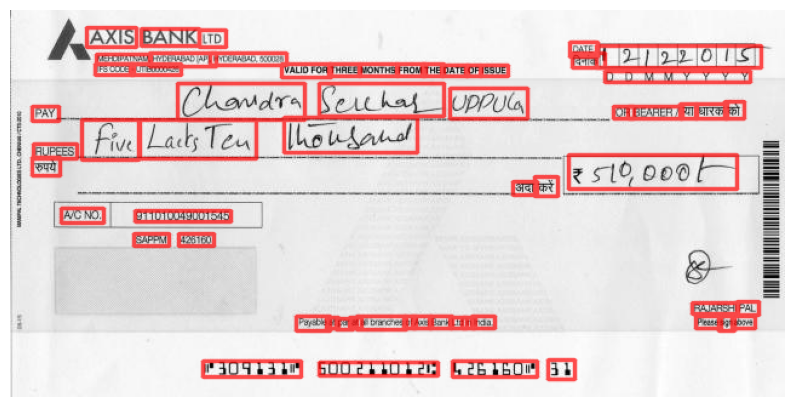

In [144]:
_ = words_dets.draw()

In [190]:
gcv_lines_dets = gcv_dets.group_bboxes(paragraph_break=0.02)

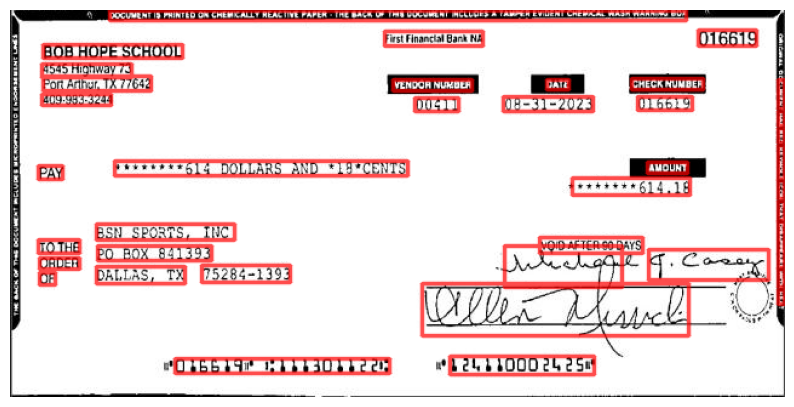

In [191]:
_ = gcv_lines_dets.draw()

In [151]:
sav_dict = vars(gcv_dets)

In [158]:
# del sav_dict["parent_ds"]
del sav_dict["np_img"]

In [159]:
import pandas as pd

In [184]:
d = {
    "boxes": [{'x1': 33, 'x2': 34},
    "y": 5
}

In [185]:
{**d.pop("boxes")}

{'x1': 33, 'x2': 34}

In [164]:
def _as_df(det, ignore_keys=["parent_ds", "np_img"], flatten_keys=["bboxes"]):
    mydict = { k:v for k,v in vars(det).items() if k not in ignore_keys }
    l_flattened_dicts = {

In [178]:
df["bboxes"]

0    [{'x1': 206, 'y1': 279, 'x2': 333, 'y2': 293, ...
1    [{'x1': 210, 'y1': 286, 'x2': 445, 'y2': 300, ...
2    [{'x1': 365, 'y1': 290, 'x2': 435, 'y2': 303, ...
3    [{'x1': 521, 'y1': 257, 'x2': 535, 'y2': 265, ...
Name: bboxes, dtype: object

## testing load ylo

In [84]:
yolo_dets, yolo_ds = load_yolo("../data/public/dataset.yml",
                               subset="train")

2024-02-20 11:59:54.243 | INFO     | chequeparser.datasets.loaders:load_yolo:23 - Loading labels from ../data/public/labels


  0%|          | 0/236 [00:00<?, ?it/s]

2024-02-20 11:59:54.257 | INFO     | chequeparser.utilities.io_utils:get_files:35 - Found 235 files.
2024-02-20 11:59:54.270 | WARNING  | chequeparser.utilities.io_utils:change_suffixes:57 - Found 0 non-existent files
2024-02-20 11:59:54.271 | WARNING  | chequeparser.utilities.io_utils:change_suffixes:58 - Few samples: []


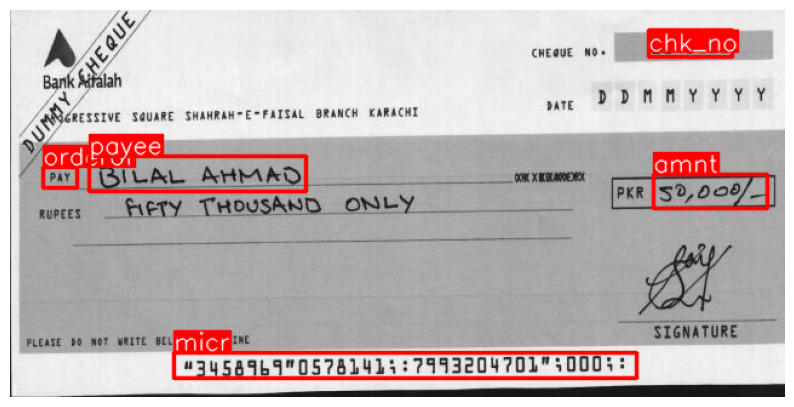

In [87]:
yolo_dets[-10].draw(yolo_ds, show_label=True)